## EEE485 - Project Final

### Imports

In [1]:
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy.linalg as LA
import smote
import random
import kNN
import fcn
import PCA
from numba import njit, jit
import scipy
from logistic_regression import Logistic_regression
from GradBoost import BinaryGradientBoostClassify
from PCA import PCAnalyser

### Load Data

In [2]:
raw_data = pd.read_csv("data.csv")
bankrupt_pd = raw_data["Bankrupt?"]
features_pd = raw_data.drop(["Bankrupt?"], axis=1)
raw_data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


### Check for NAN and Duplicate Values


In [3]:
print("NAN values:", [col for col in features_pd if features_pd[col].isna().sum() > 0])
print("Duplicates:", features_pd.duplicated().sum())

NAN values: []
Duplicates: 0


### Evaluate Data Imbalance

In [4]:
unstable_initial = (raw_data["Bankrupt?"] == 1).sum()
stable_initial = (raw_data["Bankrupt?"] == 0).sum()
print("Data Size:", raw_data.shape[0])
print("# of stable companies:", stable_initial )
print("# of unstable companies:", unstable_initial )
print("Unstable to Stable Ratio: ", unstable_initial/stable_initial)

Data Size: 6819
# of stable companies: 6599
# of unstable companies: 220
Unstable to Stable Ratio:  0.03333838460372784


### PLOTS

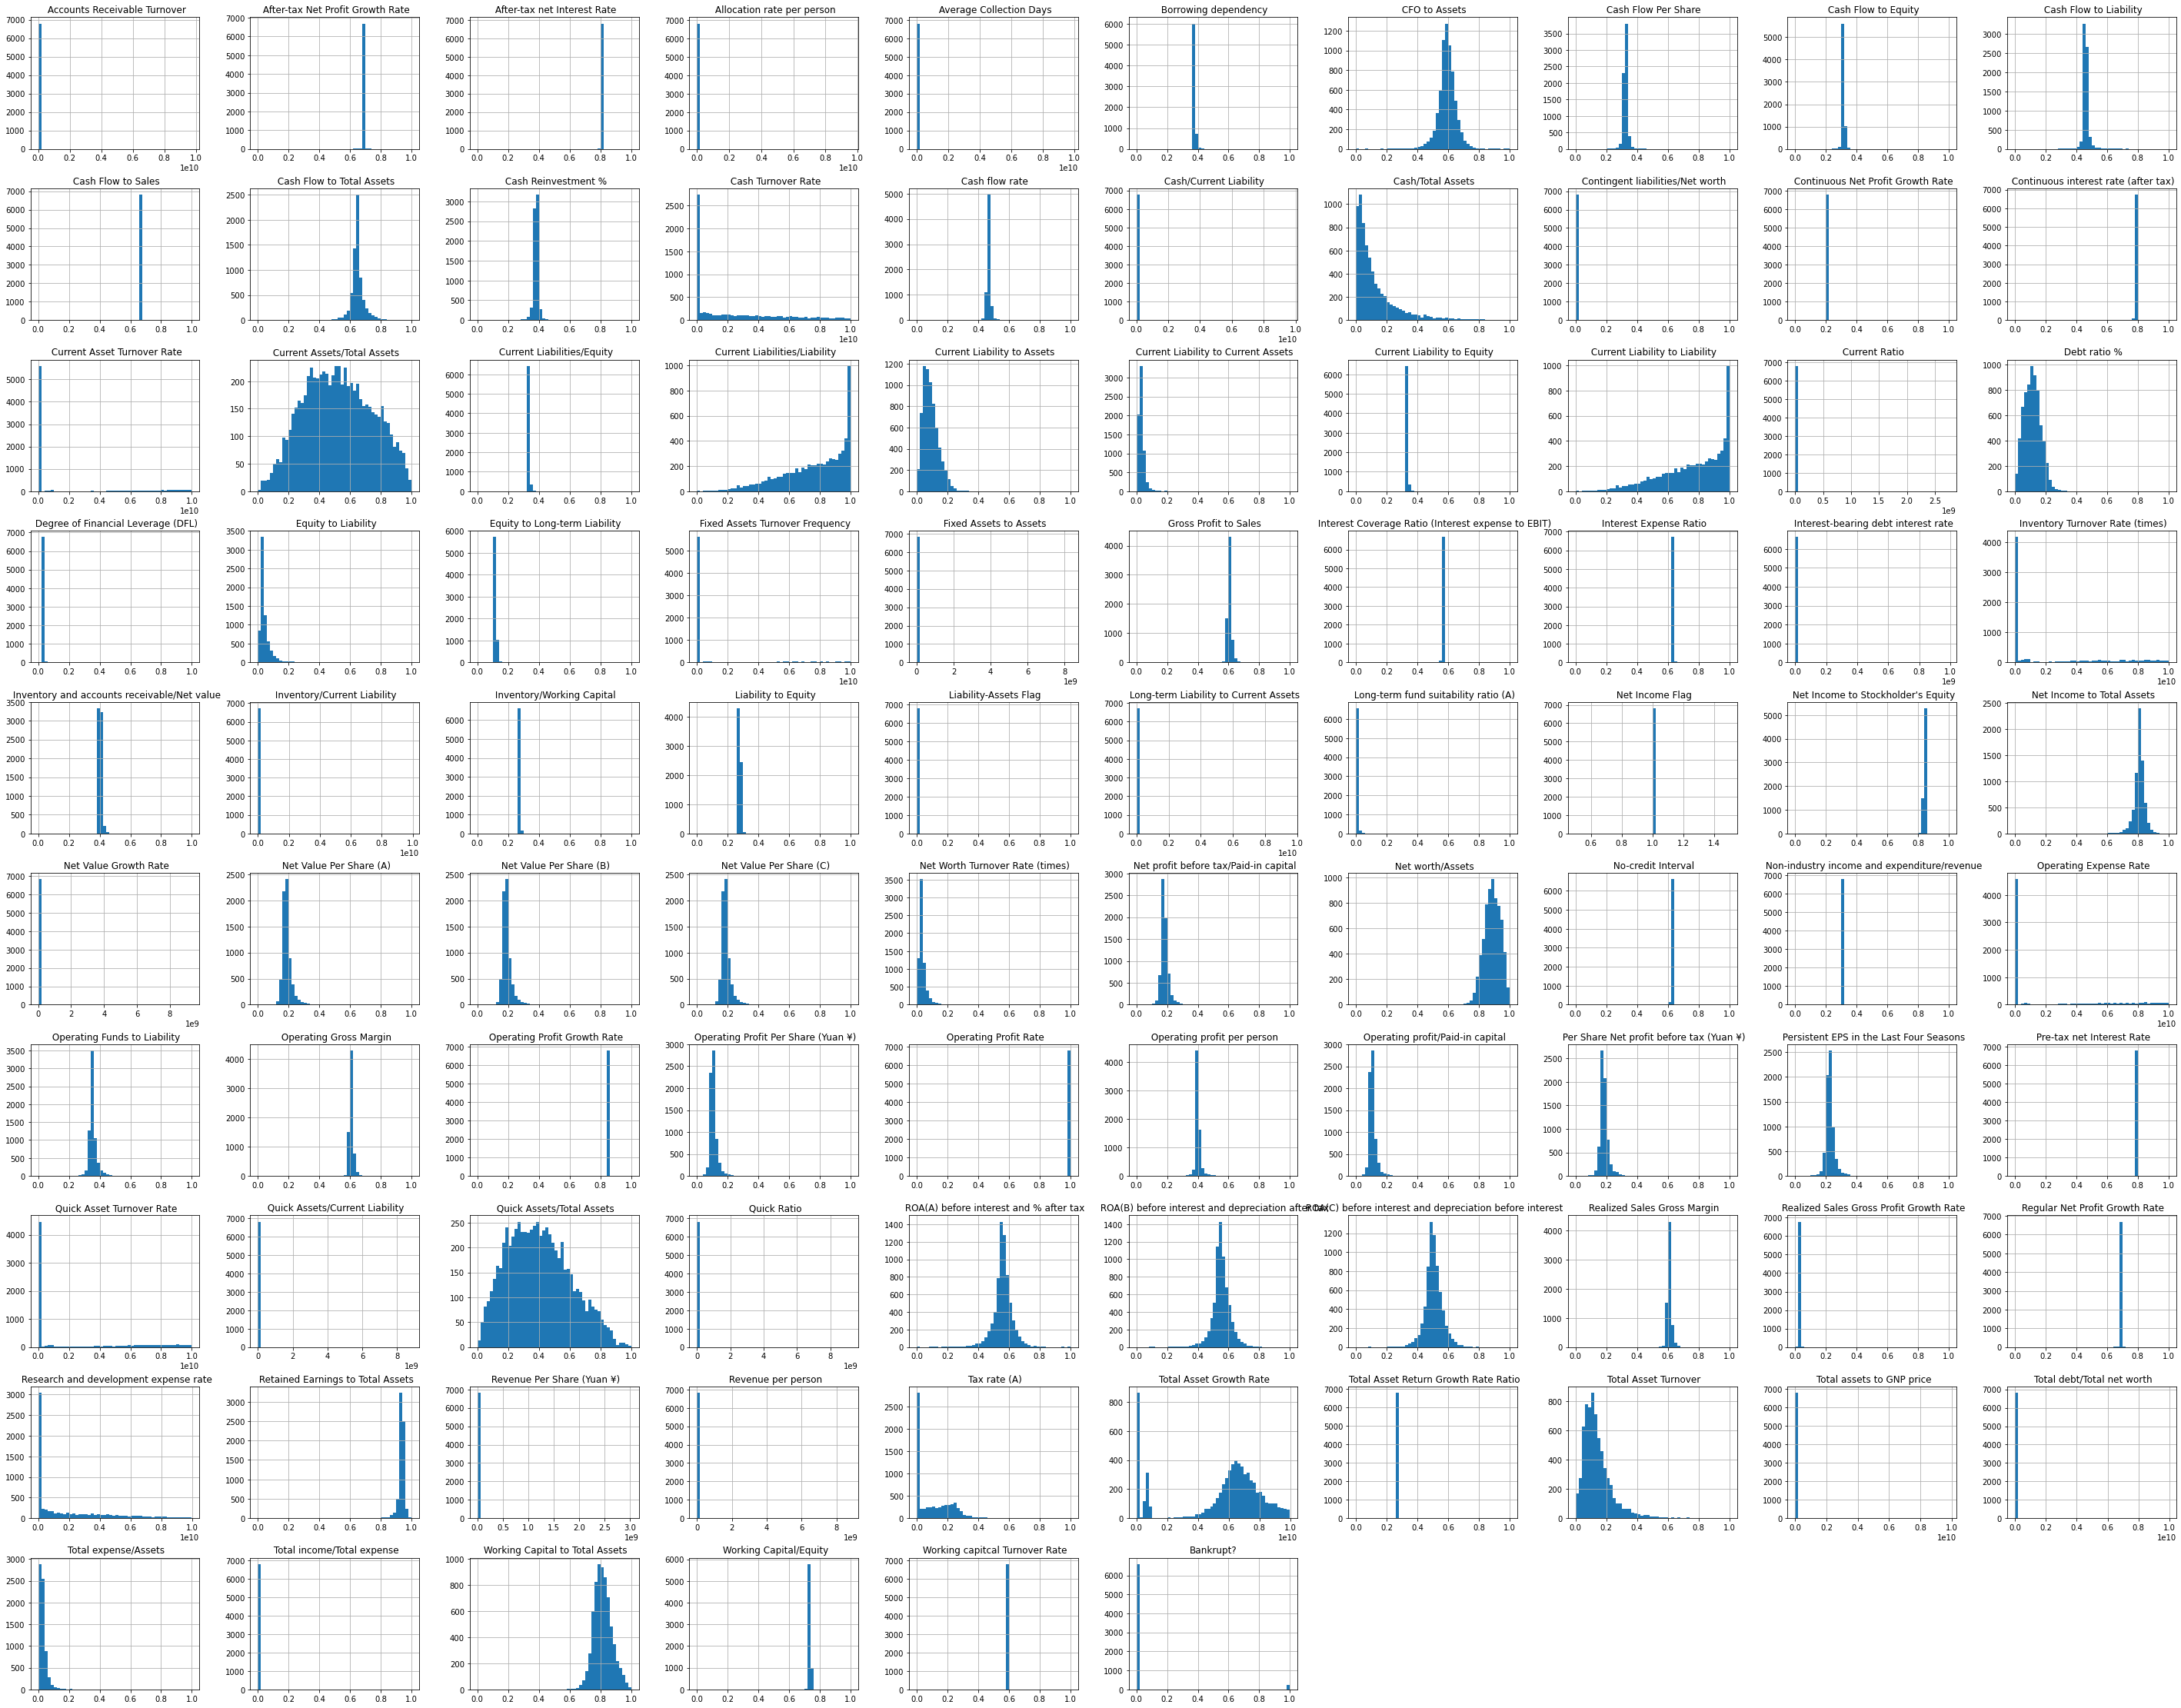

In [5]:
raw_data.hist(figsize = (50,40), bins = 50)
plt.show()

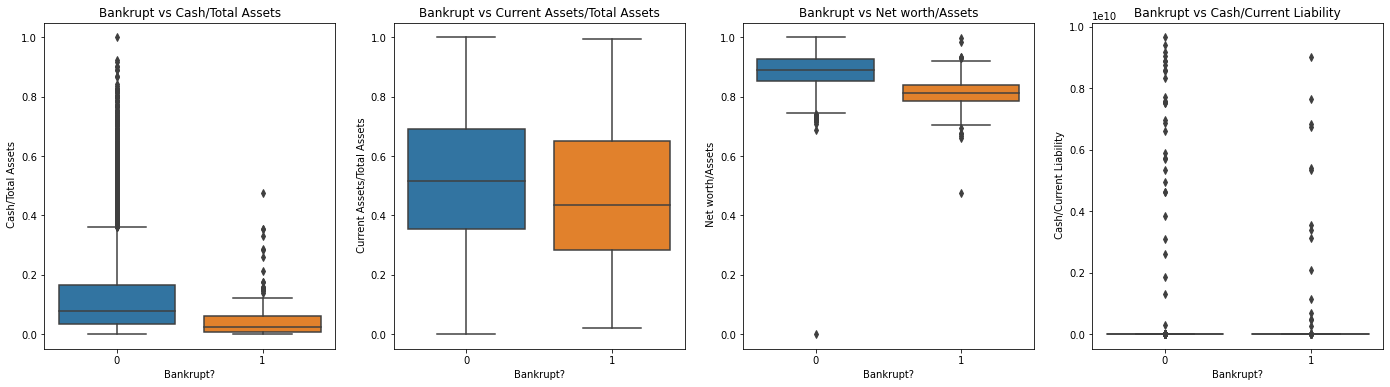

In [6]:
f, axes = plt.subplots(ncols=4, figsize = (24,6) )

sns.boxplot(x="Bankrupt?", y=" Cash/Total Assets", data=raw_data, ax = axes[0] )
axes[0].set_title("Bankrupt vs Cash/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Current Assets/Total Assets", data=raw_data, ax = axes[1] )
axes[1].set_title("Bankrupt vs Current Assets/Total Assets")

sns.boxplot(x="Bankrupt?", y=" Net worth/Assets", data=raw_data, ax = axes[2] )
axes[2].set_title("Bankrupt vs Net worth/Assets")

sns.boxplot(x="Bankrupt?", y=" Cash/Current Liability", data=raw_data, ax = axes[3] )
axes[3].set_title("Bankrupt vs Cash/Current Liability")

plt.show()

### Outlier Removal Using IQR

In [7]:
clean_data = raw_data.copy(deep=True)
for col in features_pd:
    clean_data = fcn.remove_outlier(raw_data[col], str(col), raw_data)
clean_data = clean_data.reset_index(drop=True)
clean_data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0,0.491639,0.549498,0.537877,0.613219,0.613168,0.998999,0.797436,0.809344,0.303543,...,0.806743,0.000548,0.623743,0.613219,0.840676,0.276560,0.026811,0.565253,1,0.061753
6266,0,0.477600,0.531127,0.526099,0.595829,0.595858,0.998905,0.797375,0.809294,0.303634,...,0.794028,0.003475,0.623398,0.595827,0.839864,0.281325,0.022309,0.571752,1,0.024803
6267,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6268,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284


### PCA

In [8]:
clean_X = clean_data.drop(["Bankrupt?"], axis=1)
clean_Y = clean_data["Bankrupt?"]
centered_data = clean_X - np.mean(clean_X, axis=0)
pc_analyser = PCAnalyser(centered_data, data_centered=True)
eigen_vals, PCs = pc_analyser.analyse(k=7)
PCA_data = centered_data @ PCs

(0.0, 30.0)

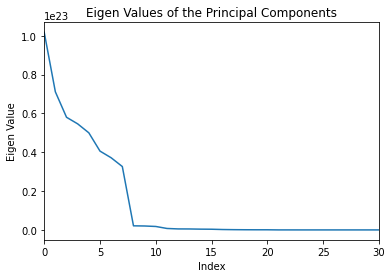

In [9]:
plt.figure(figsize=(6,4))
plt.plot(eigen_vals)
plt.xlabel("Index")
plt.ylabel("Eigen Value")
plt.title("Eigen Values of the Principal Components")
plt.xlim( (0, 30) )

In [10]:
PCA_data.columns = ("PC"+str(i) for i in range(1,8))
print("Shape of the Feature Matrix after PCA is:", PCA_data.shape)
print("PVE of the chosen PC's are:", pc_analyser.calc_PVE(m=7))
PCA_data = pd.concat([clean_Y, PCA_data], axis=1)

Shape of the Feature Matrix after PCA is: (6270, 7)
PVE of the chosen PC's are: 0.9802926054463157


### SMOTE

In [11]:
minority = PCA_data[PCA_data["Bankrupt?"] == 1] # Extract minority samples from data
smt = smote.Smote( minority.to_numpy() ) # Initialize the SMOTE class
oversamples = smt.oversample(N=2600) # Employ SMOTE oversampling


In [12]:
smote_data = PCA_data.copy(deep=True) # Cleared from outliers and dim reduced by PCA. Now oversample
oversamples_pd = pd.DataFrame(oversamples, columns = PCA_data.columns)
smote_data = smote_data.append(oversamples_pd)
smote_data = smote_data.reset_index(drop=True)

In [13]:
unstable_smote = (smote_data["Bankrupt?"] == 1).sum()
stable_smote = (smote_data["Bankrupt?"] == 0).sum()
print("Oversampled Data Size:", smote_data.shape[0])
print("Number of Stable Companies:", stable_smote)
print("Number of Unstable Companies (with SMOTE):", unstable_smote)
print("unstable to Stable Ratio: ", unstable_smote/stable_smote, sep="")

Oversampled Data Size: 11938
Number of Stable Companies: 6052
Number of Unstable Companies (with SMOTE): 5886
unstable to Stable Ratio: 0.972571050892267


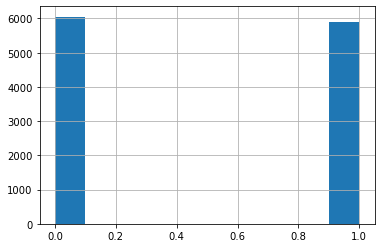

In [14]:
smote_data["Bankrupt?"].hist()
plt.show()

### Test Train Split

In [15]:
test_ratio = 0.1
#Smote
smote_data = smote_data.sample(frac=1).reset_index(drop=True)
train_sm, test_sm = fcn.test_train_split(smote_data, test_ratio )
X_train_sm = train_sm.drop(["Bankrupt?"], axis=1)
Y_train_sm = train_sm["Bankrupt?"]
X_test_sm = test_sm.drop(["Bankrupt?"], axis=1)
Y_test_sm = test_sm["Bankrupt?"]
#No Smote
train, test = fcn.test_train_split(PCA_data, test_ratio )
X_train = train.drop(["Bankrupt?"], axis=1)
Y_train = train["Bankrupt?"]
X_test = test.drop(["Bankrupt?"], axis=1)
Y_test = test["Bankrupt?"]

X_train_np = X_train.to_numpy()
Y_train_np = Y_train.to_numpy()
X_test_np = X_test.to_numpy()
Y_test_np = Y_test.to_numpy()
X_train_sm_np = X_train_sm.to_numpy()
Y_train_sm_np = Y_train_sm.to_numpy()
X_test_sm_np = X_test_sm.to_numpy()
Y_test_sm_np = Y_test_sm.to_numpy()


### k-Nearest Neighbors Classifier (with and without SMOTE)

In [16]:
knn_classifier = kNN.k_NN_classifier(X_train_np, Y_train_np )
knn_preds = np.zeros_like(Y_test_np)
for idx, test in enumerate(X_test_np):
    knn_preds[idx] = knn_classifier.classify(test)

knn_classifier_sm = kNN.k_NN_classifier(X_train_sm_np, Y_train_sm_np )
knn_sm_preds = np.zeros_like(Y_test_sm_np)
for idx, test in enumerate(X_test_sm_np):
    knn_sm_preds[idx] = knn_classifier_sm.classify(test)


In [17]:
print("Confusion Matrix Without SMOTE")
conf_matrix = fcn.confusion_matrix(Y_test_np, knn_preds, ret = True)

print("Recall:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0]) * 100 )
print("Precision:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]) * 100 )
print()
print("Confusion Matrix With SMOTE")
conf_matrix_sm = fcn.confusion_matrix(Y_test_sm_np, knn_sm_preds, ret = True)
print("Recall:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[1,0]) * 100 )
print("Precision:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[0,1]) *100 )

Confusion Matrix Without SMOTE
 1	0 (actual)
1	0	2
0	19	606
Recall: 0.0
Precision: 0.0

Confusion Matrix With SMOTE
 1	0 (actual)
1	578	105
0	20	490
Recall: 96.65551839464884
Precision: 84.62664714494875


### Logistic Regression

In [18]:
log_reg = Logistic_regression(7)
initial_weights = np.random.rand(7,1)
weights = Logistic_regression.gradient_descent(X_train_sm_np, Y_train_sm_np.reshape(len(Y_train_sm_np),1), initial_weights)
for idx in range(10000):
    weights = Logistic_regression.gradient_descent(X_train_sm_np, Y_train_sm_np.reshape(len(Y_train_sm_np),1), weights)
final_pred =Logistic_regression.pred(X_test_sm_np, weights)
result = Logistic_regression.classify(final_pred)

c:\Users\c\Desktop\EEE485_Project-master\logistic_regression.py:11: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1 + np.exp(-z))


In [19]:
conf_matrix_sm_lr = fcn.confusion_matrix(Y_test_sm_np.T, result.T*1, ret = True)
print("Recall:", conf_matrix_sm_lr[0,0]/(conf_matrix_sm_lr[0,0]+conf_matrix_sm_lr[1,0]) * 100 )
print("Precision:", conf_matrix_sm_lr[0,0]/(conf_matrix_sm_lr[0,0]+conf_matrix_sm_lr[0,1]) *100 )

 1	0 (actual)
1	355	321
0	243	274
Recall: 59.36454849498328
Precision: 52.51479289940828


### Gradient Boosting Classifier

In [20]:
grad_boost_sm = BinaryGradientBoostClassify(6, 0.065, 5, 1e-5, 17)
grad_boost_sm.fit(X_train_sm_np, Y_train_sm_np)
y_pred_sm = grad_boost_sm.predict(X_test_sm_np)
y_pred = grad_boost_sm.predict(X_test_np)

In [21]:
print("on SMOTE Data")
conf_matrix_sm = fcn.confusion_matrix(Y_test_sm_np, y_pred_sm, show=True)
print("Recall:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[1,0]) * 100 )
print("Precision:", conf_matrix_sm[0,0]/(conf_matrix_sm[0,0]+conf_matrix_sm[0,1]) *100 )
print("\non Real Data")
conf_matrix = fcn.confusion_matrix(Y_test_np, y_pred, show = True)
print("Recall:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0]) * 100 )
print("Precision:", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]) *100 )

on SMOTE Data
 1	0 (actual)
1	500	71
0	98	524
Recall: 83.61204013377926
Precision: 87.56567425569177

on Real Data
 1	0 (actual)
1	19	6
0	0	602
Recall: 100.0
Precision: 76.0
